# Analyzing Austin PD's Crime Reports Dataset

The dataset is available from the Austin Police Department on https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu. It is updated weekly and I last downloaded the dataset on 10/6/2020.  



## Table of Contents 

    I. Introduction
    II. Data Scrubbing
    III. Exploratory Analysis 
    IV. Summary
    
    Questions:
><ul>
><li><a href="#q1"> 1. What areas of Austin have the highest crime rates?</a></li>
><li><a href="#q2"> 2. How is crime distributed in 78753?</a></li> 
><li><a href="#q3"> 3. How is crime distributed in 78741?</a></li>
><li><a href="#q4"> 4. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed?
><li><a href="#q5"> 5. What significant does the family violence factor play, in violent crime, over time? 
><li><a href="#q6"> 6. How does murder appear on the map?
</a></li>

## I. Introduction

I began reviewing the Crime Reports dataset, provided by the Austin PD, around the same time I began reviewing its Hate Crimes datasets for analysis, at the beginning of 2020. This is a rather large dataset, containing over 2 million records, spanning from 2003 to the present, and is updated weekly. 

This is a self-paced project, conceived outside of both work and the educational arenas. It is my hope that this project will reveal some actionable insights that will benefit the Austin law enforcement community, news outlets, and anyone else interested in gaining knowledge on how best to combat the problem of crime in the Austin area.

I originally attempted importing the data into this notebook using Sodapy's Socrata API method but found it cumbersome. Mainly, it didn't want to work with importing the entire dataset, and added several redundant columns. I, therefore, prefer to manually download the entire dataset and re-download each week after it's updated.

In [1]:
# Importing essential libraries and configurations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import folium
from folium import plugins
import seaborn as sns 

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 
              None)
plt.style.use('seaborn-white')

In [2]:
# Loading the data
df = pd.read_csv('crime_reports.csv')

In [3]:
# Examining the dataframe
display(df.info())
print('----------------------------------')
display(df.duplicated().sum())
print('----------------------------------')
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2273307 entries, 0 to 2273306
Data columns (total 27 columns):
Incident Number                int64
Highest Offense Description    object
Highest Offense Code           int64
Family Violence                object
Occurred Date Time             object
Occurred Date                  object
Occurred Time                  float64
Report Date Time               object
Report Date                    object
Report Time                    float64
Location Type                  object
Address                        object
Zip Code                       float64
Council District               float64
APD Sector                     object
APD District                   object
PRA                            object
Census Tract                   float64
Clearance Status               object
Clearance Date                 object
UCR Category                   object
Category Description           object
X-coordinate                   float64
Y-coordin

None

----------------------------------


0

----------------------------------


Incident Number                      0
Highest Offense Description          0
Highest Offense Code                 0
Family Violence                      0
Occurred Date Time                 165
Occurred Date                        0
Occurred Time                       84
Report Date Time                     1
Report Date                          0
Report Time                          1
Location Type                    20856
Address                             12
Zip Code                         13839
Council District                 46936
APD Sector                        8784
APD District                      9253
PRA                              10488
Census Tract                   1446453
Clearance Status                602974
Clearance Date                  333762
UCR Category                   1500219
Category Description           1500219
X-coordinate                      9909
Y-coordinate                      9909
Latitude                         38331
Longitude                

## II. Data Scrubbing

There are several columns of data we won't be using in the analysis, mainly other date and geodata columns. So we'll drop those and also scrub some others. Mainly, we want the zip code and address columns to be free of nulls and duplicates. 

The Clearance Status column contains 3 types of statuses: Y for Yes, N for No, and O which stands for "cleared by other means than arrest." Therefore, I changed the column to bool with Y and O as True, and N as False. However, you may note that areas, where there is no clearance status at all, may or may not contain a corresponding date in the clearance date column. I am unsure how best to handle this so I am open to suggestions or advice.   

In [4]:
# Helper function for scrubbing the data
def clean_data(df):
    drop_col = ['Occurred Time', 
                'Occurred Date', 
                'Report Date', 
                'Report Time', 
                'Census Tract', 
                'UCR Category', 
                'Category Description', 
                'X-coordinate', 
                'Y-coordinate', 
                'Location']
    df.drop(drop_col, 
            axis=1, 
            inplace=True)
    clean_col = ['Zip Code', 
                 'Report Date Time', 
                 'Occurred Date Time'] 
    df.dropna(subset=clean_col, 
              inplace=True)
    df.rename(columns=lambda x: x.strip().lower().replace(" ", 
                                                          "_"), 
              inplace=True)
    """Convert the following to bools"""
    d = {'Y': True, 
         'N': False}
    e = {'C': True, 
         'O': True, 
         'N': False}
    df.clearance_status = df.clearance_status.map(e)
    df.clearance_status = df.clearance_status.astype('bool')
    df.family_violence = df.family_violence.map(d)
    df.family_violence = df.family_violence.astype('bool') 
    """Convert the following to datetime type"""
    date_col = ['occurred_date_time', 
                'clearance_date', 
                'report_date_time'] 
    """Convert the following to category type"""
    cat_col = ['highest_offense_description', 
               'location_type', 
               'apd_sector'] 
    df[date_col] = df[date_col].astype('datetime64') 
    df[cat_col] = df[cat_col].astype('category') 
    """Convert the following to integer type"""
    int_col = ['zip_code']
    df['year'] = pd.to_datetime(df['occurred_date_time'], 
                                format='%m/%d/%Y').dt.year 
    df['month'] = pd.to_datetime(df['occurred_date_time'], 
                                 format='%m/%d/%Y').dt.month 
    df['hour'] = pd.to_datetime(df['occurred_date_time'], 
                                format='%m/%d/%Y').dt.hour
    df[int_col] = df[int_col].astype('int64')
    """Set the index"""
    df.set_index(['occurred_date_time'], 
                 inplace=True)
    df.sort_index(inplace=True)
    return df
df = clean_data(df)

In [5]:
# Rechecking the dataframe 
display(df.isnull().sum())
print('----------------------------------')
display(df.dtypes)
print('----------------------------------')
display(df.head())
print('----------------------------------')
display(df.tail())

incident_number                     0
highest_offense_description         0
highest_offense_code                0
family_violence                     0
report_date_time                    0
location_type                   20390
address                             0
zip_code                            0
council_district                33097
apd_sector                          8
apd_district                       11
pra                                11
clearance_status                    0
clearance_date                 330544
latitude                        27684
longitude                       27684
year                                0
month                               0
hour                                0
dtype: int64

----------------------------------


incident_number                         int64
highest_offense_description          category
highest_offense_code                    int64
family_violence                          bool
report_date_time               datetime64[ns]
location_type                        category
address                                object
zip_code                                int64
council_district                      float64
apd_sector                           category
apd_district                           object
pra                                    object
clearance_status                         bool
clearance_date                 datetime64[ns]
latitude                              float64
longitude                             float64
year                                    int64
month                                   int64
hour                                    int64
dtype: object

----------------------------------


,incident_number,highest_offense_description,highest_offense_code,family_violence,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,pra,clearance_status,clearance_date,latitude,longitude,year,month,hour
occurred_date_time,,,,,,,,,,,,,,,,,,,
2003-01-01,20125003299,IDENTITY THEFT,4022,False,2012-01-23 09:41:00,SPECIALTY STORE (TV FUR ETC.),1533 CUTTING HORSE LN,78727,7.0,ED,4,193,False,2012-01-23,30.416668,-97.683656,2003,1,0
2003-01-01,20125033273,AGG SEXUAL ASSAULT CHILD/OBJEC,1712,False,2012-07-18 12:00:00,RESIDENCE / HOME,1100 BLOCK HARVEY ST,78702,1.0,CH,2,415,True,2013-02-27,NaN,NaN,2003,1,0
2003-01-01,20035011395,FORGERY AND PASSING,1000,False,2003-09-13 09:35:00,COMMERCIAL / OFFICE BUILDING,8501 BURNET RD,78757,7.0,ID,7,234,True,2003-09-15,30.366117,-97.727721,2003,1,0
2003-01-01,2005901307,SEXUAL ASSAULT OF CHILD/OBJECT,1707,False,2005-03-31 16:40:00,RESIDENCE / HOME,6600 BLOCK ED BLUESTEIN BLVD,78723,NaN,ED,3,299,True,2005-07-12,NaN,NaN,2003,1,0
2003-01-01,20095044565,IDENTITY THEFT,4022,False,2009-08-07 14:23:00,RESIDENCE / HOME,6800 MC NEIL DR,78729,6.0,AD,4,169,True,NaT,30.438983,-97.759669,2003,1,0


----------------------------------


,incident_number,highest_offense_description,highest_offense_code,family_violence,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,pra,clearance_status,clearance_date,latitude,longitude,year,month,hour
occurred_date_time,,,,,,,,,,,,,,,,,,,
2020-10-03 16:34:00,20205039794,THEFT,600,False,2020-10-03 16:34:00,RESIDENCE / HOME,4413 EAST HOVE LOOP,78749,8.0,DA,7,86,True,NaT,30.200943,-97.854087,2020,10,16
2020-10-03 17:40:00,20205039809,BURGLARY OF VEHICLE,601,False,2020-10-03 18:04:00,PARKING LOTS / GARAGE,1900 E 7TH ST,78702,1.0,CH,2,418,True,NaT,30.262804,-97.721989,2020,10,17
2020-10-03 17:48:00,20205039808,HARASSMENT,2703,False,2020-10-03 17:48:00,RESIDENCE / HOME,1941 GASTON PLACE DR,78723,1.0,ID,4,295,True,NaT,30.312126,-97.688964,2020,10,17
2020-10-03 18:55:00,20202771232,VIOL OF BOND CONDITIONS,3006,False,2020-10-03 18:55:00,OTHER / UNKNOWN,2410 BUCKS RUN,78744,2.0,FR,8,530,True,NaT,30.182180,-97.759409,2020,10,18
2020-10-03 22:45:00,20205039833,BURGLARY OF RESIDENCE,500,False,2020-10-03 23:35:00,RESIDENCE / HOME,7104 KILDARE CV,78724,1.0,CH,7,302,True,NaT,30.298558,-97.641669,2020,10,22


## III. Exploratory Analysis

First, let's get an overall look at crime rates and how they trend over time...

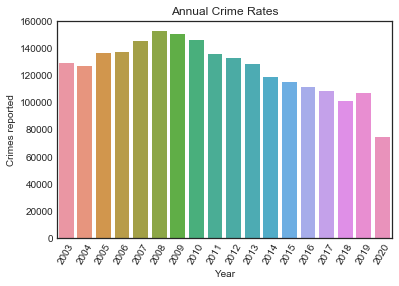

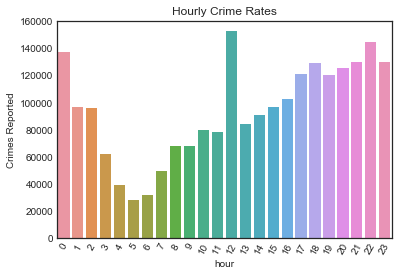

In [6]:
# Creating and visualizing a data frame for the overall yearly crime rate since 2003
crimes_per_year = df['year'].value_counts().sort_index() 

g = sns.barplot(x=crimes_per_year.index, 
                y=crimes_per_year.values)
g.set_xticklabels(g.get_xticklabels(), 
                  rotation=60)
g.set(xlabel='Year', 
      ylabel='Crimes reported', 
      title='Annual Crime Rates')
plt.show()

# Overall hourly crime rates as well
crimes_per_hour = df['hour'].value_counts().sort_index()

e = sns.barplot(x=crimes_per_hour.index, 
                y=crimes_per_hour.values)
e.set_xticklabels(e.get_xticklabels(), 
                  rotation=60)
e.set(xlabel='hour', 
      ylabel='Crimes Reported', 
      title='Hourly Crime Rates')
plt.show()

Between 2003 and now, crime peaked in 2008 and continued a downward trend until 2019 when it rose again. Since we're still in 2020, we have to wait until the end of the year to see what 2020 yields. 

<a id='q1'></a>
### A. Question 1. What areas of Austin have the highest crime rates? 

***Note: I am only including zipcodes and crimes, for questions 1 - 3, that >= 1%. Any zipcodes or crime percentages, below 1%, will be discluded to simplify analysis and visualizations.***

Question 4 regards violent crime. For violent crime, I chose to examine 4 categories: aggrivated assault, rape, murder, and capital murder. I realize there are other types of violent crime, but for now I am sticking with these 4 categories. 

78741    204550
78753    176468
78701    167037
78758    156939
78704    152845
78745    149052
78702    135675
78744    124819
78723    116948
78752     83573
78748     67135
78759     65325
78751     63338
78757     57047
78705     56324
78721     47204
78749     39941
78724     37230
78727     35384
78703     34791
78731     28230
78746     27882
78729     25270
78750     23305
78754     22367
Name: zip_code, dtype: int64

----------------------------------


78741    0.090536
78753    0.078107
78701    0.073933
78758    0.069463
78704    0.067651
78745    0.065972
78702    0.060051
78744    0.055246
78723    0.051763
78752    0.036990
78748    0.029715
78759    0.028914
78751    0.028034
78757    0.025250
78705    0.024930
78721    0.020893
78749    0.017678
78724    0.016478
78727    0.015661
78703    0.015399
78731    0.012495
78746    0.012341
78729    0.011185
78750    0.010315
78754    0.009900
Name: zip_code, dtype: float64

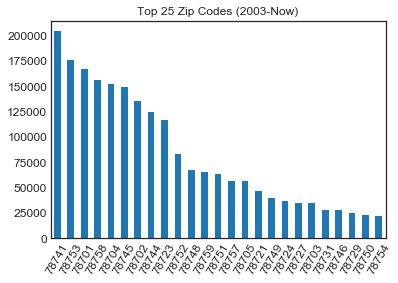

In [7]:
# Create and show dataframe for crime rates by zipcode and then as percentages
zip_codes = df.zip_code.value_counts().head(25)
display(zip_codes)
print('----------------------------------')
display(df.zip_code.value_counts(normalize=True).head(25))


# Visualizing the top 25 areas for crime 
df.zip_code.value_counts().head(25).plot.bar(fontsize=12, 
                                             rot=60, 
                                             title='Top 25 Zip Codes (2003-Now)')
plt.show()

Out of all the areas in Austin, 78741 has the highest percentage of overall crime at 9.05%. This is a significant 1.24 percentage points higher than the number 2 area 78753 which hosts 7.81% of overall crime.

#### Taking a closer look at particular areas... 

Because 78753 is my resident zipcode, I chose to examine it first. 

Next, I'll examine 78741. 

<a id='q2'></a>
### B. Question 2. How is crime distributed in 78753? 

THEFT                             16970
BURGLARY OF VEHICLE               15834
FAMILY DISTURBANCE                14379
CRIMINAL MISCHIEF                  9283
THEFT BY SHOPLIFTING               7537
ASSAULT W/INJURY-FAM/DATE VIOL     7052
BURGLARY OF RESIDENCE              6018
DWI                                4903
DISTURBANCE - OTHER                4696
CUSTODY ARREST TRAFFIC WARR        4333
HARASSMENT                         4177
AUTO THEFT                         4087
POSS OF DRUG PARAPHERNALIA         3711
PUBLIC INTOXICATION                3347
ASSAULT WITH INJURY                3249
CRIMINAL TRESPASS                  3108
POSS CONTROLLED SUB/NARCOTIC       2942
RUNAWAY CHILD                      2898
WARRANT ARREST NON TRAFFIC         2786
POSSESSION OF MARIJUANA            2685
BURGLARY NON RESIDENCE             2454
VIOL CITY ORDINANCE - OTHER        1862
Name: highest_offense_description, dtype: int64

----------------------------------


THEFT                             0.096165
BURGLARY OF VEHICLE               0.089727
FAMILY DISTURBANCE                0.081482
CRIMINAL MISCHIEF                 0.052604
THEFT BY SHOPLIFTING              0.042710
ASSAULT W/INJURY-FAM/DATE VIOL    0.039962
BURGLARY OF RESIDENCE             0.034103
DWI                               0.027784
DISTURBANCE - OTHER               0.026611
CUSTODY ARREST TRAFFIC WARR       0.024554
HARASSMENT                        0.023670
AUTO THEFT                        0.023160
POSS OF DRUG PARAPHERNALIA        0.021029
PUBLIC INTOXICATION               0.018967
ASSAULT WITH INJURY               0.018411
CRIMINAL TRESPASS                 0.017612
POSS CONTROLLED SUB/NARCOTIC      0.016672
RUNAWAY CHILD                     0.016422
WARRANT ARREST NON TRAFFIC        0.015788
POSSESSION OF MARIJUANA           0.015215
BURGLARY NON RESIDENCE            0.013906
VIOL CITY ORDINANCE - OTHER       0.010551
Name: highest_offense_description, dtype: float64

Text(0.5, 1.0, 'Crime Distribution (78753)')

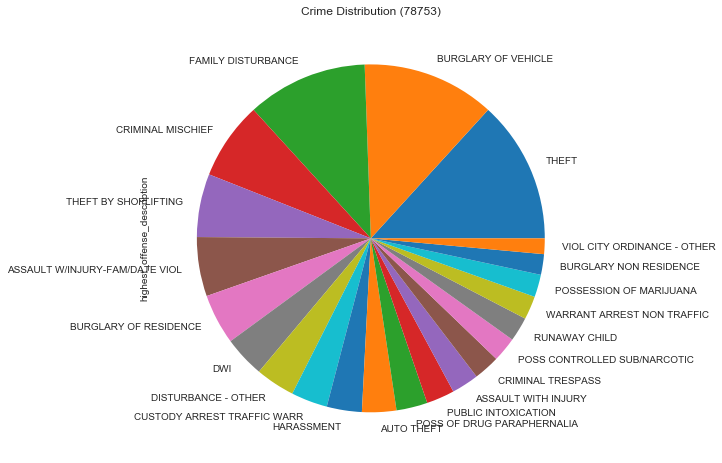

In [8]:
# Examining crime in the 78753 area
df_53 = df[df.zip_code == 78753]

# Create a dataframe for the top 10 crime categories in the zipcode
df_53_off = df_53.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages 
display(df_53_off)
print('----------------------------------')
display(df_53.highest_offense_description.value_counts(normalize=True).head(22))

df_53_off.plot.pie(figsize=(8,8))
plt.title('Crime Distribution (78753)')

<a id='q3'></a>
### C. Question 3. How is crime distributed in 78741? 

FAMILY DISTURBANCE                20057
BURGLARY OF VEHICLE               19692
THEFT                             15431
CRIMINAL MISCHIEF                 10920
ASSAULT W/INJURY-FAM/DATE VIOL     9562
BURGLARY OF RESIDENCE              8811
PUBLIC INTOXICATION                6361
CUSTODY ARREST TRAFFIC WARR        6011
DWI                                5614
HARASSMENT                         5436
DISTURBANCE - OTHER                5103
AUTO THEFT                         4509
ASSAULT WITH INJURY                4486
CRIMINAL TRESPASS                  3861
POSS CONTROLLED SUB/NARCOTIC       3821
POSSESSION OF MARIJUANA            3785
THEFT BY SHOPLIFTING               3558
POSS OF DRUG PARAPHERNALIA         3520
WARRANT ARREST NON TRAFFIC         3448
RUNAWAY CHILD                      2774
VIOL CITY ORDINANCE - OTHER        2195
Name: highest_offense_description, dtype: int64

----------------------------------


FAMILY DISTURBANCE                0.098054
BURGLARY OF VEHICLE               0.096270
THEFT                             0.075439
CRIMINAL MISCHIEF                 0.053385
ASSAULT W/INJURY-FAM/DATE VIOL    0.046747
BURGLARY OF RESIDENCE             0.043075
PUBLIC INTOXICATION               0.031098
CUSTODY ARREST TRAFFIC WARR       0.029386
DWI                               0.027446
HARASSMENT                        0.026575
DISTURBANCE - OTHER               0.024947
AUTO THEFT                        0.022044
ASSAULT WITH INJURY               0.021931
CRIMINAL TRESPASS                 0.018876
POSS CONTROLLED SUB/NARCOTIC      0.018680
POSSESSION OF MARIJUANA           0.018504
THEFT BY SHOPLIFTING              0.017394
POSS OF DRUG PARAPHERNALIA        0.017209
WARRANT ARREST NON TRAFFIC        0.016857
RUNAWAY CHILD                     0.013561
VIOL CITY ORDINANCE - OTHER       0.010731
Name: highest_offense_description, dtype: float64

Text(0.5, 1.0, 'Crime Distribution (78741)')

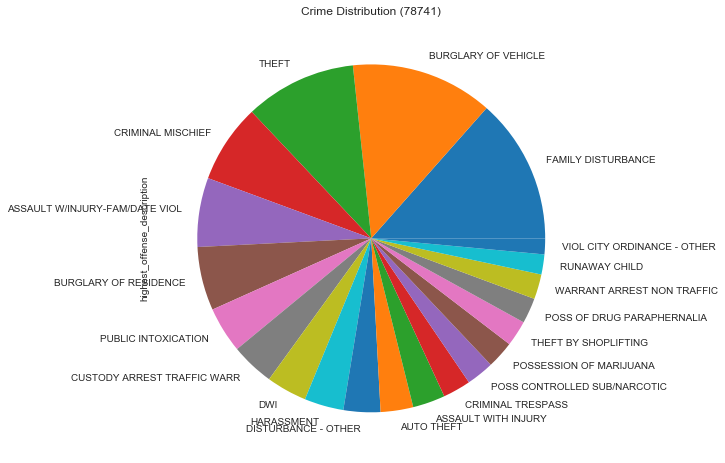

In [9]:
# Create a dataframe for crime in the 78741 area (the highest amount of crime of any Austin zip code)
df_41 = df[df.zip_code == 78741]

# Create a dataframe for the top 10 crime categories in the zipcode
df_41_off = df_41.highest_offense_description.value_counts().head(21)

# Display the different crime values & then as percentages 
display(df_41_off)
print('----------------------------------')
display(df_41.highest_offense_description.value_counts(normalize=True).head(21))

df_41_off.plot.pie(figsize=(8,8))
plt.title('Crime Distribution (78741)')

<a id='q4'></a>
### D. Question 4. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed? 

***The following line of code shows crime rates only >= 1% per zipcode.***

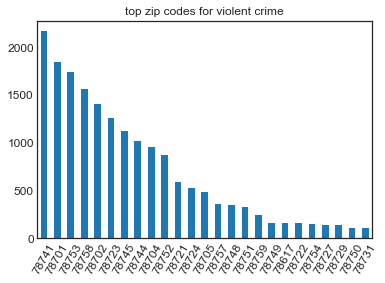

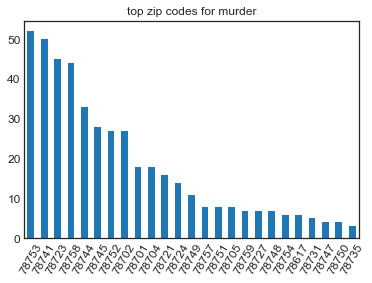

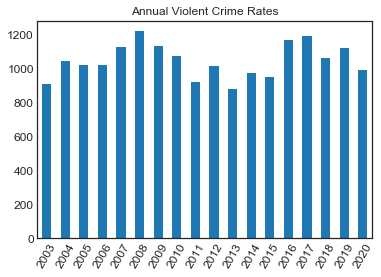

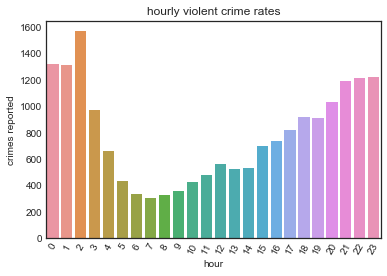

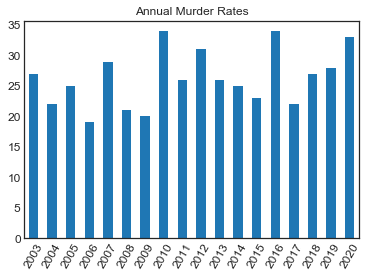

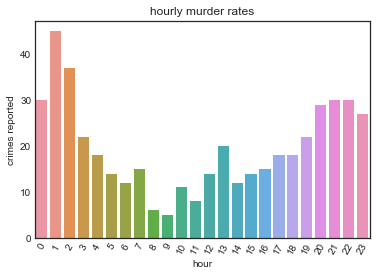

highest_offense_description,AGG ASSAULT,CAPITAL MURDER,MURDER,RAPE
zip_code,,,,
78610,1,0,0,0
78613,14,0,1,6
78617,118,0,6,36
78621,1,0,0,0
78634,1,0,0,0
78652,2,0,0,0
78653,10,0,1,1
78660,66,0,2,17
78664,3,0,0,0


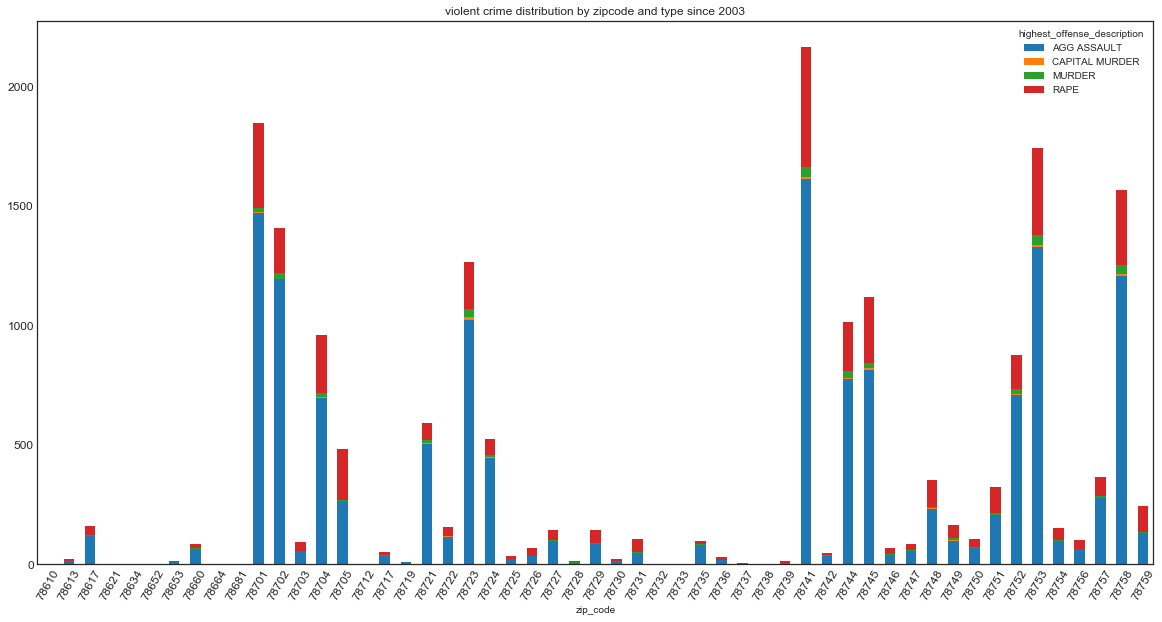

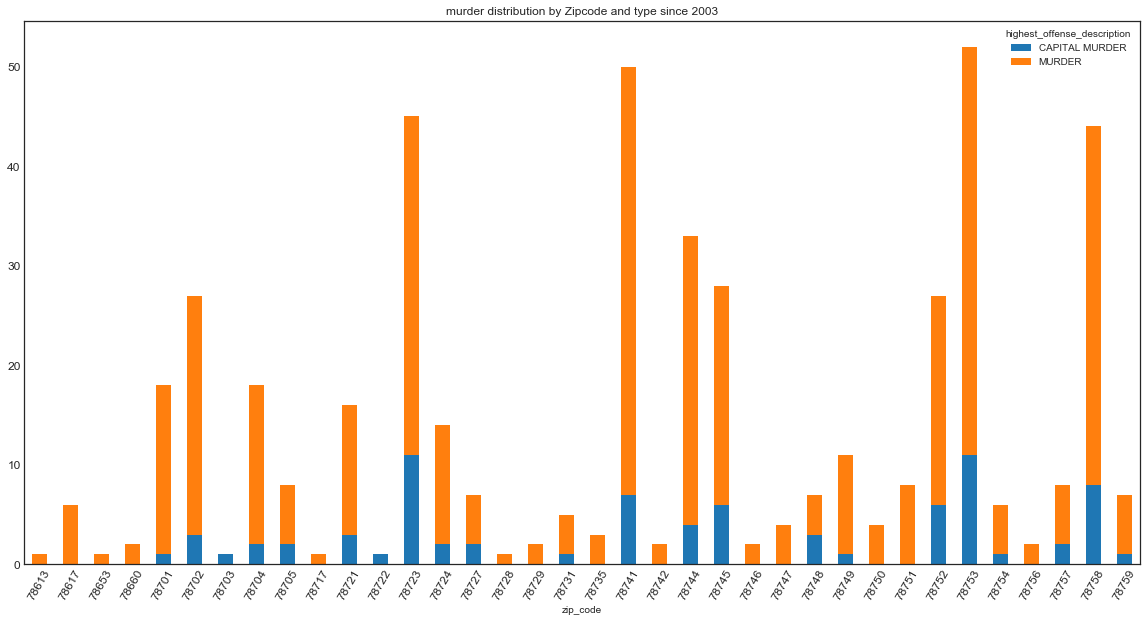

In [10]:
# Creating an overall and separate dataframes for violent crime
df_viol = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER", "RAPE", "AGG ASSAULT"]') 
df_viol_mur = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER"]')
df_mur = df[df.highest_offense_description == 'MURDER']
df_mur_cap = df[df.highest_offense_description == 'CAPITAL MURDER']
df_agg_asslt = df[df.highest_offense_description == 'AGG ASSAULT']
df_rape = df[df.highest_offense_description == 'RAPE']

#Violent Crime by Zipcode
df_viol_zip = df_viol.zip_code.value_counts().head(25)

df_viol_zip.plot.bar(title='top zip codes for violent crime', 
                     fontsize=12,  
                     rot=60)
plt.show()

# Murder by Zipcode
df_viol_mur.zip_code.value_counts().head(25).plot.bar(fontsize=12, 
                                                      title='top zip codes for murder', 
                                                      rot=60)
plt.show()

# Visualizing violent crimes per year
viol_per_year = df_viol['year'].value_counts().sort_index()

viol_per_year.plot.bar(rot=60,
                        title='Annual Violent Crime Rates', 
                        fontsize=12)
plt.show()

viol_by_hour = df_viol['hour'].value_counts().sort_index()

h = sns.barplot(x=viol_by_hour.index, 
                y=viol_by_hour.values)
h.set_xticklabels(h.get_xticklabels(), 
                  rotation=60)
h.set(xlabel='hour', 
      ylabel='crimes reported', 
      title='hourly violent crime rates')
plt.show()

# Visualizing murders per year
viol_mur_per_year = df_viol_mur['year'].value_counts().sort_index()

viol_mur_per_year.plot.bar(rot=60, 
                            title='Annual Murder Rates', 
                            fontsize=12)
plt.show()
        
mur_by_hour = df_viol_mur['hour'].value_counts().sort_index()

# Visualizing hourly murder rate with Seaborn
f = sns.barplot(x=mur_by_hour.index, 
                y=mur_by_hour.values)
f.set_xticklabels(f.get_xticklabels(), 
                  rotation=60)
f.set(xlabel='hour', 
      ylabel='crimes reported', 
      title='hourly murder rates')
plt.show()

# Calculating and visualizing frequency rate of violent crimes by zipcode
viol_freq = pd.crosstab(df_viol.zip_code, 
                        df_viol.highest_offense_description)

display(viol_freq)

viol_freq.plot.bar(figsize=(20,10), 
                   title='violent crime distribution by zipcode and type since 2003', 
                   fontsize=12, 
                   stacked=True, 
                   rot=60)
plt.show()

viol_mur_freq = pd.crosstab(df_viol_mur.zip_code, df_viol_mur.highest_offense_description)

viol_mur_freq.plot.bar(figsize=(20,10), 
                       title='murder distribution by Zipcode and type since 2003', 
                       fontsize=12, 
                       stacked=True,  
                       rot=60)
plt.show()

According to the data , 2010 and 2016 had the most number of murders . Alarmingly, this year so far has already become the 3rd most prevalent year.

<a id='q5'></a>
### E. Question 5. What significance has the family violence factor played over time? 

0.0583384528768884

----------------------------------


occurred_date_time
2003    0.039437
2004    0.045315
2005    0.049476
2006    0.054267
2007    0.058797
2008    0.058310
2009    0.055014
2010    0.052704
2011    0.060332
2012    0.061661
2013    0.057999
2014    0.057622
2015    0.062611
2016    0.066117
2017    0.067792
2018    0.074290
2019    0.070205
2020    0.075284
Name: family_violence, dtype: float64

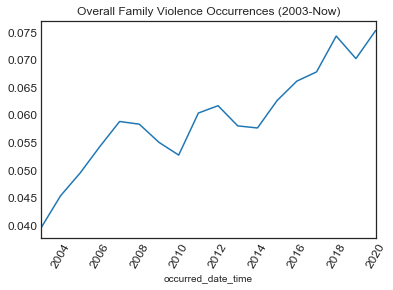

0.07820546854260685

----------------------------------


occurred_date_time
2003    0.035242
2004    0.036329
2005    0.048039
2006    0.043180
2007    0.056788
2008    0.069558
2009    0.066960
2010    0.062384
2011    0.079090
2012    0.082840
2013    0.109339
2014    0.123975
2015    0.129066
2016    0.100769
2017    0.097234
2018    0.113101
2019    0.080357
2020    0.077387
Name: family_violence, dtype: float64

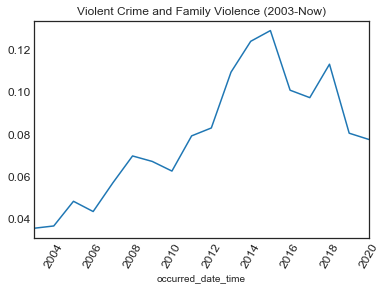

0.2055084745762712

----------------------------------


occurred_date_time
2003    0.148148
2004    0.090909
2005    0.320000
2006    0.105263
2007    0.068966
2008    0.238095
2009    0.050000
2010    0.264706
2011    0.230769
2012    0.225806
2013    0.307692
2014    0.240000
2015    0.304348
2016    0.117647
2017    0.181818
2018    0.222222
2019    0.321429
2020    0.212121
Name: family_violence, dtype: float64

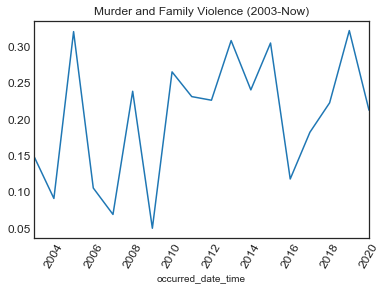

0.23062155027597792

----------------------------------


occurred_date_time
2003    0.154321
2004    0.083721
2005    0.105820
2006    0.126316
2007    0.169355
2008    0.194805
2009    0.205240
2010    0.169421
2011    0.265537
2012    0.271795
2013    0.279188
2014    0.281065
2015    0.294498
2016    0.330882
2017    0.293515
2018    0.257732
2019    0.256522
2020    0.301887
Name: family_violence, dtype: float64

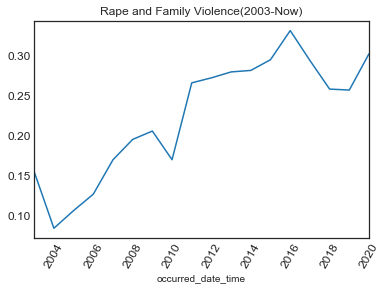

0.23062155027597792

----------------------------------


occurred_date_time
2003    0.004172
2004    0.022250
2005    0.026055
2006    0.022222
2007    0.023529
2008    0.036082
2009    0.031603
2010    0.021303
2011    0.027778
2012    0.030457
2013    0.050382
2014    0.032626
2015    0.040258
2016    0.027746
2017    0.029613
2018    0.052490
2019    0.025522
2020    0.027397
Name: family_violence, dtype: float64

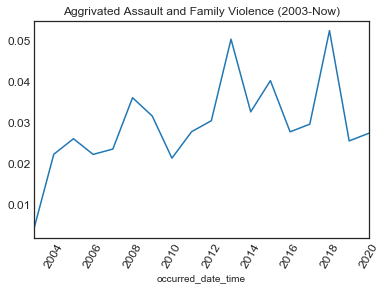

In [11]:
# Taking a look at first at the overall crime set
display(df.family_violence.mean())

print('----------------------------------')
display(df.groupby(df.index.year).family_violence.mean())

hrly_fam_viol_occurrences = df.groupby(df.index.year).family_violence.mean()

fam_viol_avg = df.groupby(df.index.year).family_violence.mean()

fam_viol_avg.plot(rot=60, 
                  fontsize=12, 
                  title='Overall Family Violence Occurrences (2003-Now)')
plt.show()

# Now taking a look at violent crime specifically 
display(df_viol.family_violence.mean())

print('----------------------------------')
display(df_viol.groupby(df_viol.index.year).family_violence.mean())

viol_hrly_fam_viol_occurrences = df_viol.groupby(df_viol.index.year).family_violence.mean()

viol_fam_viol_avg = df_viol.groupby(df_viol.index.year).family_violence.mean()

viol_fam_viol_avg.plot(rot=60, 
                       fontsize=12, 
                       title='Violent Crime and Family Violence (2003-Now)')
plt.show()

# Now taking a look at murder with the family violence factor included 
display(df_viol_mur.family_violence.mean())

print('----------------------------------')
display(df_viol_mur.groupby(df_viol_mur.index.year).family_violence.mean())

mur_hrly_fam_viol_occurrences = df_viol_mur.groupby(df_viol_mur.index.year).family_violence.mean()

mur_fam_viol_avg = df_viol_mur.groupby(df_viol_mur.index.year).family_violence.mean()

mur_fam_viol_avg.plot(rot=60, 
                      fontsize=12, 
                      title='Murder and Family Violence (2003-Now)')
plt.show()

# Now taking a look at rape with the family violence factor included 
display(df_rape.family_violence.mean())

print('----------------------------------')
display(df_rape.groupby(df_rape.index.year).family_violence.mean())

rape_hrly_fam_viol_occurrences = df_rape.groupby(df_rape.index.year).family_violence.mean()

rape_fam_viol_avg = df_rape.groupby(df_rape.index.year).family_violence.mean()

rape_fam_viol_avg.plot(rot=60, 
                       fontsize=12, 
                       title='Rape and Family Violence(2003-Now)')
plt.show()

# Now taking a look at aggrivated assault with the family violence factor included 
display(df_rape.family_violence.mean())

print('----------------------------------')
display(df_agg_asslt.groupby(df_agg_asslt.index.year).family_violence.mean())

agg_asslt_fam_viol_avg = df_agg_asslt.groupby(df_agg_asslt.index.year).family_violence.mean()

agg_asslt_fam_viol_avg.plot(rot=60, 
                            fontsize=12, 
                            title='Aggrivated Assault and Family Violence (2003-Now)')
plt.show()

Overall, family violence is seeing an upward trend as a crime factor. Violent crime saw an alarming upward trend of the family violence factor, as well. Rapes, for example, involved the family violence factor a 3rd of the time in 2016 whereas in 2004, family violence was involved less than 1% of the time. 

<a id='q6'></a>
### F. Question 6. How does murder appear on the map? 

In [12]:
# This won't work if there are NaN values in the coordinate columns
df_viol_mur.dropna(subset=['latitude', 'longitude'], 
                   inplace=True)

# Making a folium map using incident lat and lon
m = folium.Map([30.2672, -97.7431], 
               tiles='Stamen Toner', 
               zoom_level=12)

for index, row in df_viol_mur.iterrows():
	lat = row['latitude']
	lon = row['longitude']
	name= row['address']
	folium.Marker([lat, lon], 
                  popup=name).add_to(m)
    
m.save(outfile='aus_mur_map.html')

m

## IV. Summary
Needless to say, violent crimes go hand-in-hand with other violent crimes.

So far, 78753 and 78741 are the top hotspots for all sorts of crime in Austin, including violent crime.

For non-capital murder, 78741 comes in at number 1 with 10.91%. 

#### ***It is important to note that murder does not necessarily make the defendant(s) automatically eligible for the death penalty. Under Texas law, we distinguish capital murder, through the motives and actions of the defendant(s) during the commission of a homicide, as whether or not automatically warranting an eventual date with the executioner. This includes such things as if the homicide was premeditated or not, if the defendant(s) murdered a police officer, etc.***

Regarding capital murder, 78723 comes in to share the number one spot with 78753, with a rate of 13.92% each. The 78741 area drops to the number 3 spot, carrying 8.97%. So, if we're honest, 78753 actually is the number 1 hotspot for murder because it has played host to 40 non-capital murders and 11 capital murders in total, meaning it has hosted 11% of all murders. 78741, if we combine all murders, only accounts for 10.56% of the total since 2003. 

Next, 78741 climbs back to claim the number 1 spot for rape at 12.09% -- 3.43 percentage points higher than the number 2 spot 78753 carrying 8.66% which is quite a significant lead when you look at it on the graph!! Why does rape occur so much more often in this area than in others?

A peculiar outlier is zipcode 78731. Although violent crime frequency ranks amongst the lowest there, rape accounts for over 50% of violent crimes committed in that area. Why is that? 

Astonishingly the family violence factor played an ever increasing role over over time, in regards to violent crime. From 2003 to 2015, family violence increased by nearly 10 percentage points--meaning you were likely to be the victim of a family member, during the commission of a rape, aggrivated assault, murder, or capital murder, only 3.15% of the time in 2003. But by 2015, that same likelihood rose to 12.82%!